# Introduction

This notebook explores the shapelet transformers implemented within aeon. For a wider understanding please refer to antoines notebook first.

if you want to learn about x y z then go to antoines

here youll learn about a b c

# The three transformers

In [1]:
from aeon.registry import all_estimators

for k, v in all_estimators("transformer", filter_tags={"algorithm_type": "shapelet"}):
    print(f"{k}: {v}")

c:\ProgramData\miniconda3\envs\aeon\Lib\site-packages\aeon\base\__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


RSAST: <class 'aeon.transformations.collection.shapelet_based._rsast.RSAST'>
RandomDilatedShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._dilated_shapelet_transform.RandomDilatedShapeletTransform'>
RandomShapeletTransform: <class 'aeon.transformations.collection.shapelet_based._shapelet_transform.RandomShapeletTransform'>


# A little bit about each transformer
- talk generally about the purpose of transforms as opposed to shapelet trees
- talk about their params and logic and contributions and flaws (write in order of release)

## Shapelet transform

## Random Dilated Shapelet Transform

## Scalable and Accurate Subsequence Transform

# The datasets to be explored

### (Univariate) Gun/No Gun

The Gun/NoGun motion capture time series dataset is perhaps the most studied time
series classification problem in the literature. The
dataset consists of 100 instances from each class.

This dataset involves one female actor and one male actor making a motion with their hand, sometimes holding a gun and sometimes not. The classification problem is to determine whether or not they were holding a prop or just miming the action. The problem is made somewhat more complicated by the fact that the two actors, differ in height (by 12 inches) and “style”.

The two classes are:

Gun-Draw:
- the actors have their hands by their sides. They draw a replicate gun from a hip-mounted holster, point it at a target for approximately one second, then return the gun to the holster, and their hands to their sides. 

Point:
- the actors have their gun by their sides. They point with their index fingers to a target for approximately one second, and then return their hands to their sides. 

For both classes, they study tracked the centroid of the actor's right hand in both X- and Y-axes, which appear to be highly correlated. Because of this, the data in the archive is just the X-axis - making this a univariate time series. Class 1 is "gun" and class 2 is "no gun (pointing)"

In [2]:
from aeon.datasets import load_classification
import numpy as np

X_gun_train, y_gun_train = load_classification("GunPoint", split="train")
X_gun_test, y_gun_test = load_classification("GunPoint", split="test")

X_gun_full = np.concatenate((X_gun_train, X_gun_test), axis=0)

print(f"shape of the array: {X_gun_full.shape}")
print(f"Number of training samples = {X_gun_train.shape[0]}")
print(f"Number of testing samples = {X_gun_test.shape[0]}")
print(f"n_channels = {X_gun_train.shape[1]}")
print(f"n_timepoints = {X_gun_train.shape[2]}")

shape of the array: (200, 1, 150)
Number of training samples = 50
Number of testing samples = 150
n_channels = 1
n_timepoints = 150


As you can see, we have 200 different time series each 150 datapoints long. The train/test split follows the original paper with 50 samples taken for training and the rest for testing, with each actor and class being equally represented in each. 

**I want to know why the training sets are smaller than testing**

Eamonn was setting up the archive he made the train sets smaller to make the problem harder to solve

### (Multivariate) Motion

This human activity recognition dataset is time series data generated by accelerometer and gyroscope sensors (attitude, gravity, user acceleration, and rotation rate) used in the paper {Malekzadeh et al., Mobile Sensor Data Anonymization, in proc the International Conference on Internet of Things Design and Implementation, 2019 (Link Here) A total of 24 participants in a range of gender, age, weight, and height performed 6 activities in 15 trials in the same environment and conditions: downstairs (dws), upstairs , walking, jogging, sitting, and standing.

In [3]:
from aeon.datasets import load_classification

X_motion_train, y_motion_train = load_classification("MotionSenseHAR", split="train")
X_motion_test, y_motion_test = load_classification("MotionSenseHAR", split="test")

print(f"shape of the array: {X_motion_train.shape}")
print(f"n_samples = {X_motion_train.shape[0]}")
print(f"n_channels = {X_motion_train.shape[1]}")
print(f"n_timepoints = {X_motion_train.shape[2]}")

shape of the array: (966, 12, 1000)
n_samples = 966
n_channels = 12
n_timepoints = 1000


# Discuss how we will explore the transform, compare them, and hopefully understand something about the motion data

- track how long it takes to fit the transform
- compare the shapelets
    - compare their discriminative ability

- run through different transformers with different configurations
- plot the output so the shapelet generated and the transformed values
- ST take the basic motion data, find the shapelets and then plot back where the shapelet is in the motion
- useful visualisation tools are ShapeletVisualizer, ShapeletTransformVisualizer

# Fitting the training data

## Fitting each transform to training data 
- with default parameters matching those from the published papers

### (Univariate) ___ dataset

#### Random Shapelet Transform

The aeon implementation of the algorithm matches the experimental parameters explored in the Gunpoint problem, the only parameter required to set was max_shapelets = 10. 

The paper filtered the GunPoint data set using the
length parameters specified in the original shapelet paper to allow for
a fair comparison between the two methods. For MAXLEN, the original always set the longest possible length to the length of
the shortest time series in the dataset. For MINLEN, they hardcoded the shortest possible length to three since three is the minimum meaningful length. 


In [4]:
import time
from aeon.transformations.collection.shapelet_based import RandomShapeletTransform


start_time = time.time()
rst_univar = RandomShapeletTransform(max_shapelets=10).fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

rst_univar.transform(X_gun_test).shape

Time taken to fit: 9.6000 seconds


(150, 10)

#### Random Dilated Shapelet Transform

This paper did not explore the Gunpoint problem, however the default parameters were defined as:

- proportion of z-normalised shapelets = 0.8
- number of shapelets to generate = 10000
- the set of possible lengths of shapelets = [11]
- The percentile boundaries used to sample the occurrence threshold: P1 = 5, P2 = 10

In [5]:
from aeon.transformations.collection.shapelet_based import RandomDilatedShapeletTransform
import time

shapelet_lengths = array = list(range(3, 151))

start_time = time.time()
rdst_univar = RandomDilatedShapeletTransform(max_shapelets=10, shapelet_lengths = shapelet_lengths).fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

rdst_univar.transform(X_gun_test).shape

Time taken to fit: 46.1164 seconds


(150, 30)

#### Scalable and Accurate Subsequence Transform

In [6]:
from aeon.transformations.collection.shapelet_based import SAST
import time

start_time = time.time()
sast = SAST().fit(X_gun_train, y_gun_train)
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Time taken to fit: {elapsed_time:.4f} seconds")

sast.transform(X_gun_test).shape

Time taken to fit: 0.1059 seconds


(150, 22050)

### (Multivariate) Motion dataset

#### Random Shapelet Transform

In [ ]:
# import time
# from aeon.transformations.collection.shapelet_based import RandomShapeletTransform

# # Start the timer
# start_time = time.time()

# rst_multivar = RandomShapeletTransform(max_shapelets=10).fit(X_motion_train, y_motion_train)
# # Stop the timer
# end_time = time.time()

# # Calculate and print the elapsed time
# elapsed_time = end_time - start_time
# print(f"Time taken to fit: {elapsed_time:.4f} seconds")

# rst_multivar.transform(X_motion_test).shape

#### Random Dilated Shapelet Transform

In [ ]:
# from aeon.transformations.collection.shapelet_based import RandomDilatedShapeletTransform
# import time
# # Start the timer
# start_time = time.time()

# rsdt_multivar = RandomDilatedShapeletTransform(max_shapelets=10000).fit(X_motion_train, y_motion_train)
# # Stop the timer
# end_time = time.time()

# # Calculate and print the elapsed time
# elapsed_time = end_time - start_time
# print(f"Time taken to fit: {elapsed_time:.4f} seconds")

# rsdt_multivar.transform(X_motion_test).shape

## Fitting each visualizer

### (Univariate) ___ dataset

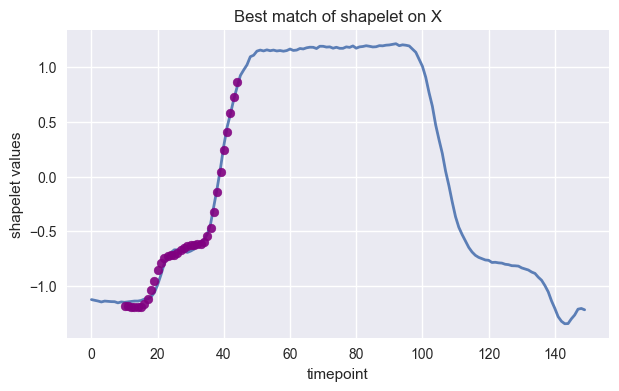

In [23]:
from aeon.visualisation import ShapeletTransformerVisualizer

rst_univar_vis = ShapeletTransformerVisualizer(rst_univar)
id_shapelet = 0  # Identifier of the shapelet

fig = rst_univar_vis.plot_on_X(id_shapelet, X_gun_test[0], figure_options={"figsize": (7, 4)})

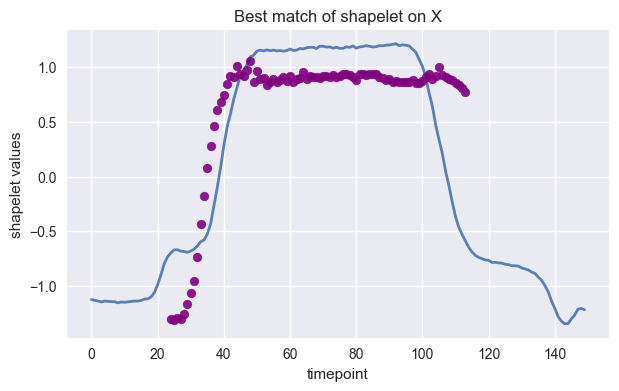

In [12]:
from aeon.visualisation import ShapeletTransformerVisualizer

rdst_univar_vis = ShapeletTransformerVisualizer(rdst_univar)
id_shapelet = 0  # Identifier of the shapelet

fig = rdst_univar_vis.plot_on_X(id_shapelet, X_gun_test[0], figure_options={"figsize": (7, 4)})

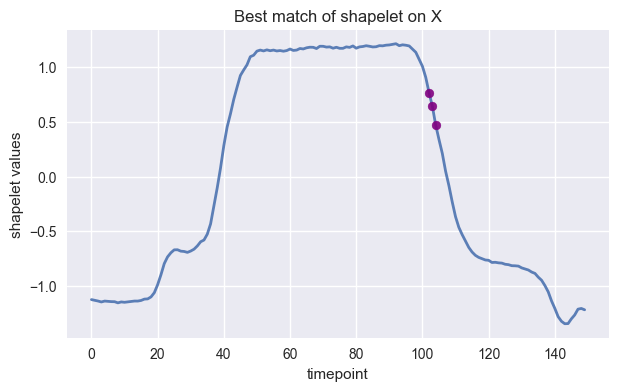

In [29]:
from aeon.visualisation import ShapeletTransformerVisualizer

sast_vis = ShapeletTransformerVisualizer(sast)
id_shapelet = 0  # Identifier of the shapelet

fig = sast_vis.plot_on_X(id_shapelet, X_gun_test[0], figure_options={"figsize": (7, 4)})

Text(0.5, 1.0, 'Distance vector of shapelet 0 on X')

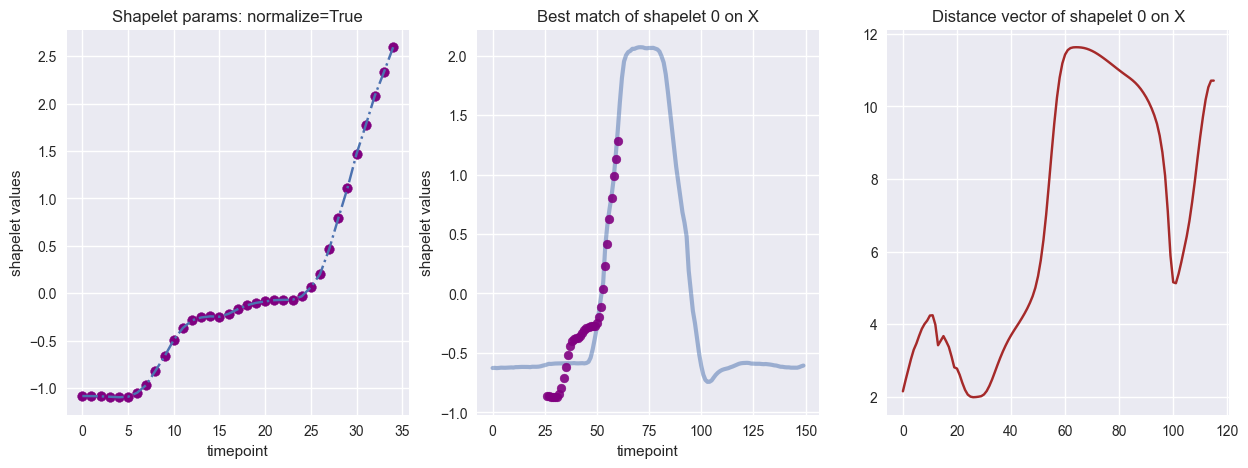

In [26]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
rst_univar_vis.plot(
    id_shapelet,
    ax=ax[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
rst_univar_vis.plot_on_X(
    id_shapelet, X_gun_test[1], ax=ax[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax[1].set_title(f"Best match of shapelet {id_shapelet} on X")
rst_univar_vis.plot_distance_vector(
    id_shapelet, X_gun_test[1], ax=ax[2], line_options={"c": "brown"}
)
ax[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

Text(0.5, 1.0, 'Distance vector of shapelet 0 on X')

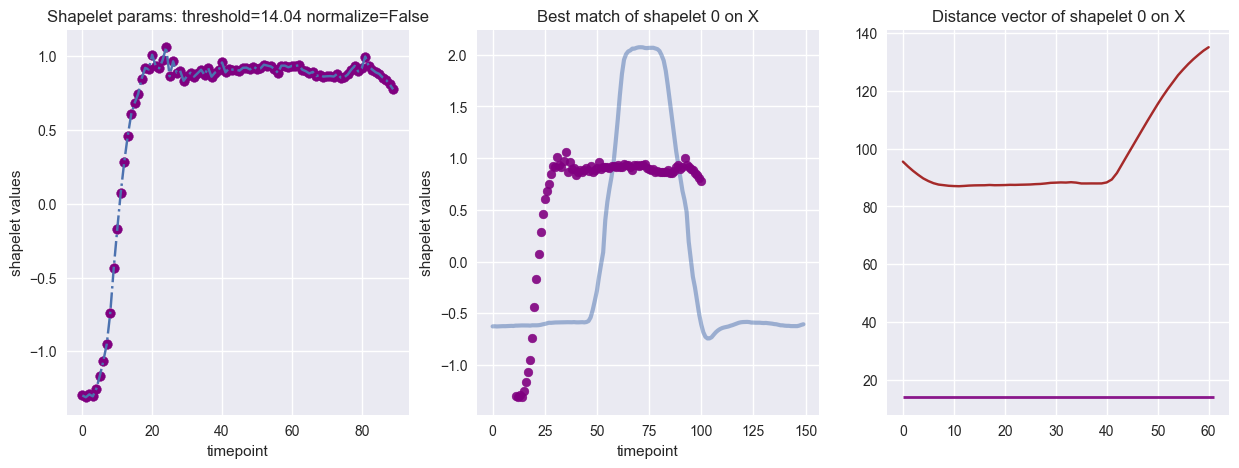

In [27]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
rdst_univar_vis.plot(
    id_shapelet,
    ax=ax[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
rdst_univar_vis.plot_on_X(
    id_shapelet, X_gun_test[1], ax=ax[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax[1].set_title(f"Best match of shapelet {id_shapelet} on X")
rdst_univar_vis.plot_distance_vector(
    id_shapelet, X_gun_test[1], ax=ax[2], line_options={"c": "brown"}
)
ax[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

Text(0.5, 1.0, 'Distance vector of shapelet 0 on X')

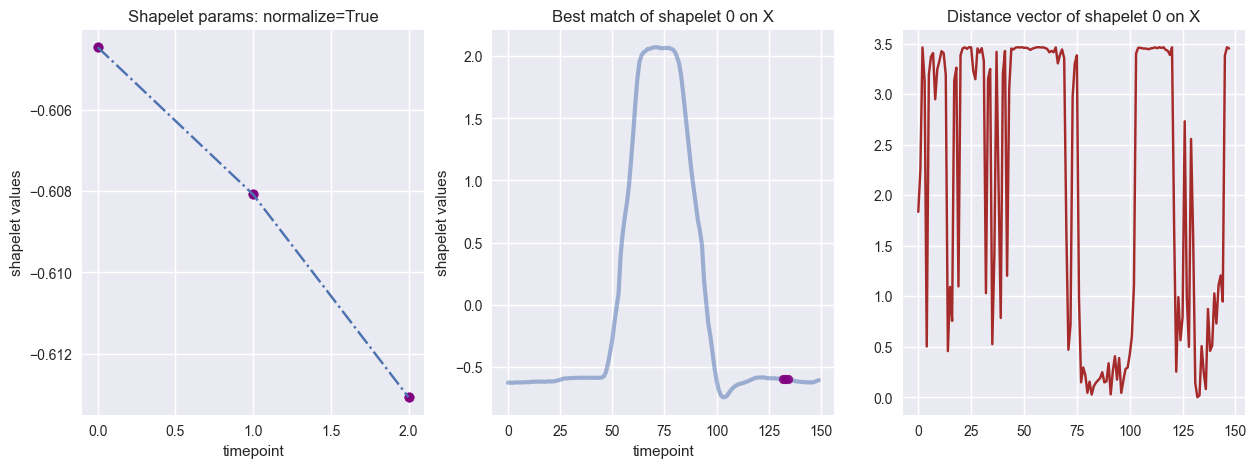

In [30]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
sast_vis.plot(
    id_shapelet,
    ax=ax[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
sast_vis.plot_on_X(
    id_shapelet, X_gun_test[1], ax=ax[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax[1].set_title(f"Best match of shapelet {id_shapelet} on X")
sast_vis.plot_distance_vector(
    id_shapelet, X_gun_test[1], ax=ax[2], line_options={"c": "brown"}
)
ax[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

### (Multivariate) motion dataset

In [ ]:
from aeon.visualisation import ShapeletTransformerVisualizer

st_vis = ShapeletTransformerVisualizer(st)
id_shapelet = 0  # Identifier of the shapelet

fig = st_vis.plot_on_X(id_shapelet, X_test[1], figure_options={"figsize": (7, 4)})

In [ ]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
st_vis.plot(
    id_shapelet,
    ax=ax[0],
    scatter_options={"c": "purple"},
    line_options={"linestyle": "-."},
)
st_vis.plot_on_X(
    id_shapelet, X_test[1], ax=ax[1], line_options={"linewidth": 3, "alpha": 0.5}
)
ax[1].set_title(f"Best match of shapelet {id_shapelet} on X")
st_vis.plot_distance_vector(
    id_shapelet, X_test[1], ax=ax[2], line_options={"c": "brown"}
)
ax[2].set_title(f"Distance vector of shapelet {id_shapelet} on X")

# Interpreting the data

## RST GunNoGun

we can see that the NoGun class has a “dip” where the actor puts her hand down by
her side, and inertia carries her hand a little too far and she is forced to correct for it
(a phenomenon known as “overshoot”). In contrast, when the actor has the gun, she
returns her hand to her side more carefully, feeling for the gun holster, and no dip is
seen.

In [19], they identified that the most important shapelet for classification was when the actor lowered their arm; if they had no gun, a phenomenon called overshoot occurred and caused a dip in the data.
<br>
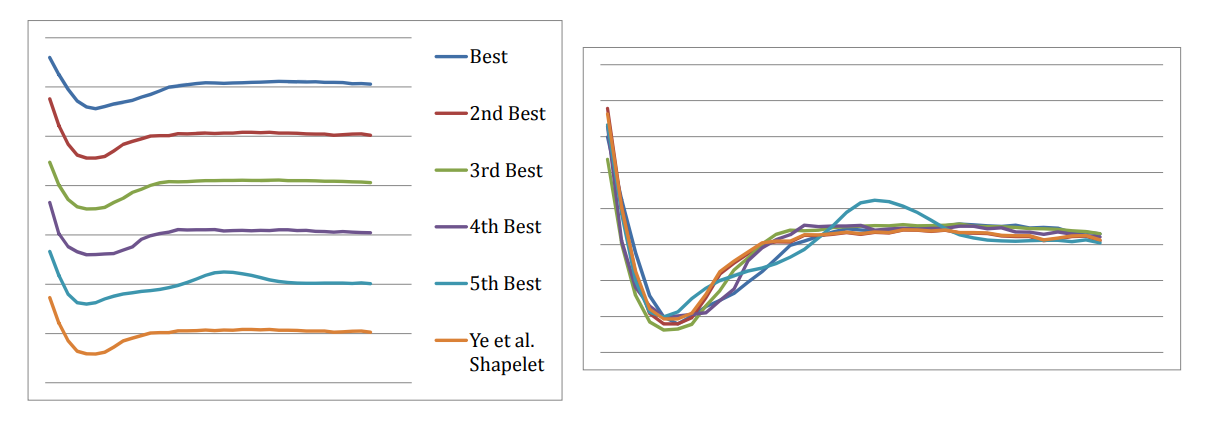
<br>
The shapelet decision tree trained by [19] contains a single
shapelet corresponding to the arm being lowered back into
position at the end of the series.

- To demonstrate that our
filter agrees with this and extracts the important information
from the data, we filtered the GunPoint data set using the
length parameters specified in the original paper to allow for
a fair comparison between the two methods. The top five
shapelets that we extracted are presented in Figure 5, along
with the shapelet reported by [19].
- The graphs in Figure 5 show that each of the top five
shapelets from our filter were very closely matched with
the shapelet from [19], reinforcing the notion that our filter
produces interpretable results. Furthermore, if we extract
the top ten shapelets from the filter we can gain even further
insight. Figure 6 shows that the top ten shapelets form two
distinct clusters. Interestingly, the shapelets to the left of the
figure correspond to the moments where the arm is lifted and
are instances where there is a gun. These shapelets could
correspond to the subtle extra movements required to lift the
prop, aiding classification by providing more information.
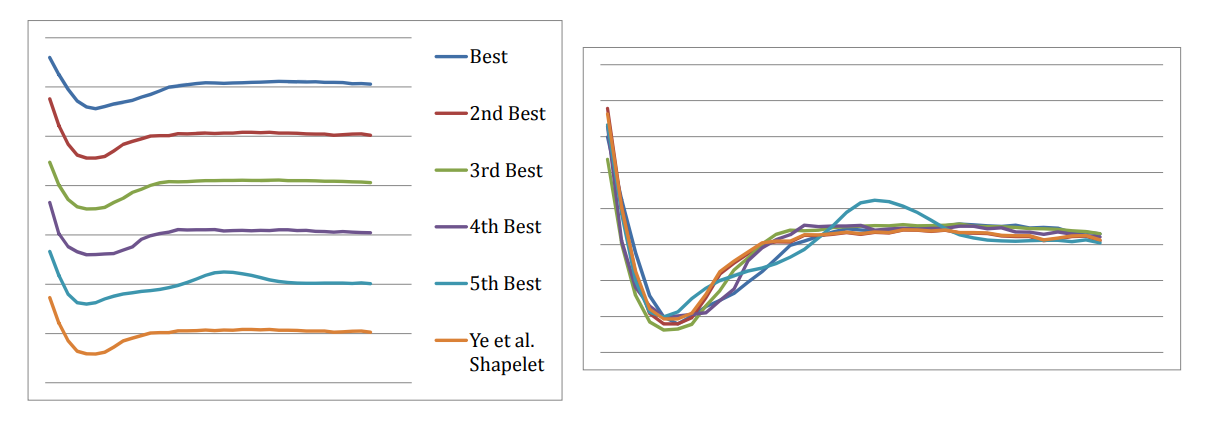

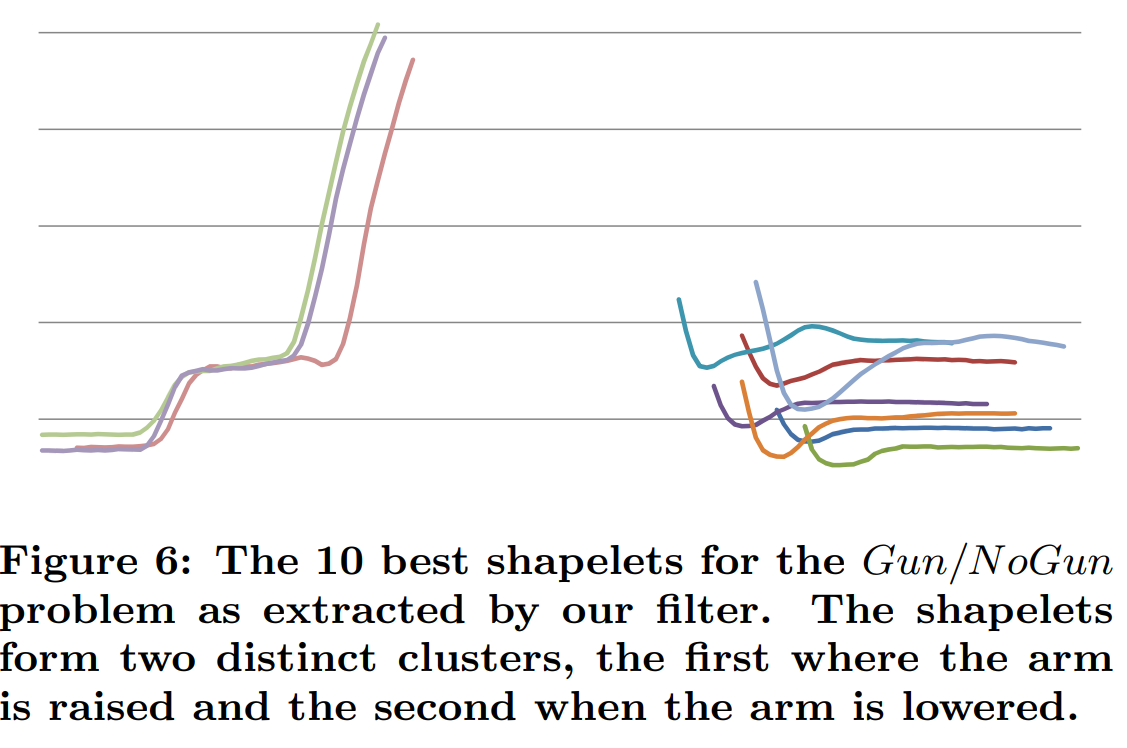



In the case where subsampling completely
removes one actor from the training data, the performance on the test set, where the two
actors are present, could be reduced.